**David Cardenas** - RA 230293

**Leonardo de Melo Joao** - RA 228118

**Matheus Cerqueira** - RA 234983  

**Walter Perez Casas** - RA 187990


    

# **Introduction**


 A Reinforcement Learning (RL) problem has two main elements: the agent and the environment; The agent acts and interacts with the environment, the latter produces rewards and a new state for the agent. Given this scenario, our goal is to find agents that learn sequences of actions that produce the maximum possible reward.
 
 In a RL problem, for each time $t$ only the current state affects the action decision, the problem could be modeled as a Markovian Decision process (MDP). Therefore, for each time point $t = 0,1,2,...$, the agent will be in a state $s_{t}$ from a set $S$, and for each state the agent can chose an action $a_{t}$ from an action set $A(s_{t})$, receiving an reward $r_{t+1}$ after the complete action $a_{t}$ and moving to the new state $s_{t+1}$. Furthermore, the reward and the next state follows a probability mass function $p(r_{t+1} | s_{t},a_{t})$ and $p(s_{t+1} | s_{t},a_{t})$, where for deterministic problem a single value is used instead of a probabilistic distribution.

  This work is an extension of a previously presented project, which had as objective the implementation of a set of classic reinforcement-learning algorithms to create agents capable of winning in the game of Pacman using a custom environment. The custom environment allows for a deterministic and stochastic behavior, and the agents were trained using three algorithms: Monte Carlo control (MC), Sarsa($\lambda$), and Q-Learning. Also, each algorithm was implemented in two versions: using Q-tables and using Linear Function Approximation.

  The extension consists of replacing the traditional classic-reinforcement-learning algorithms with deep-reinforcement-learning ones. We implemented Deep Q-Network (DQN), a value-based off-policy method, and REINFORCE a policy-based on-policy method. We then compare the results and training speed between the deep-learning methods and how they compare to our top pick for the classic methods. Additionally, we tested the deep model on more complex maps to assess its generalization capabilities.

## Problem and MDP Formulation

  We start by using the same custom map presented in the last project, where the Pacman has to collect all foods and avoid the ghosts. There is no possibility of either eating a capsule or eating scared ghosts in this custom map. Besides that, the ghosts have two possible behaviors: a **stochastic** one using random horizontal moves; and a **deterministic** one, where the ghost performs a horizontal patrol, where it loops between constantly going to the left or to the right changing to the opposite direction when it hits a wall.

  We also tested the deep algorithms on a more complex map playing the classic Pacman game. We used the *small-classic* layout to do so. In these experiments, capsules can be eaten, making the ghosts scared and allowing the Pacman to eat them. After a ghost is eaten, a new non-scared ghost returns to the game. In these maps, the ghosts have random behavior.

  Although the game of Pacman is episodic, the agent may create episodes of infinite size if it runs away from the ghosts and fails to collect all the food. To circumvent this issue, we forced all episodes to end if their size exceeded one thousand actions for the custom map and three thousand for the classic maps. The maps used are depicted in the figures below.

### Custom layout

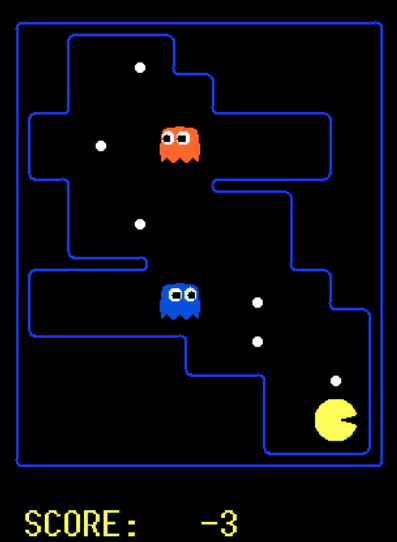

### Small-classic layout

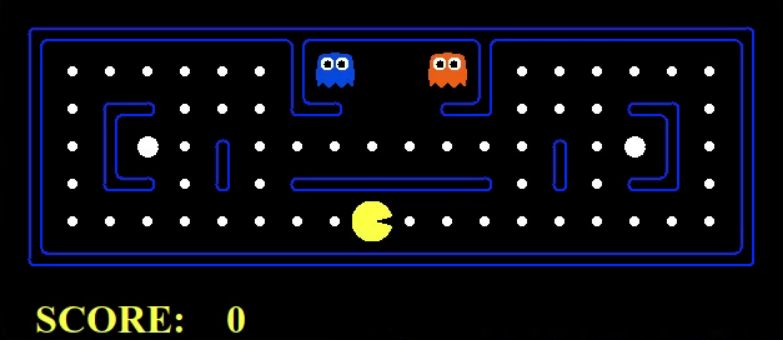

For the Pacman problem the MDP modeling resumes to:

- States: All possible configuration (i.e. pacman, ghost and foods positions);
- Actions: A finite number of actions: {North, South, West, East, Stop};
- Rewards: A real number for each combination of state and action;
- Policy:  A Map from states to actions.


|   Value  |    Motive     |
|----------|:-------------:|
| -500     |  Lose         |
| 5000     |  Win          |
| -1       |  Single action|
| 10       |  Eats a food  |


  The game ends when all food is eaten (*, i.e.,* reaches the terminal states), or the Pacman collides with a ghost.

It is worth noting that, because the agent cannot move to a wall, the number of possible actions it can take in each state depends on the number of walls adjacent to him.

  As discussed in the previous project, the MDP states are defined according to the content of each grid cell, i.e., where the Pacman, the food/capsules, and each of the ghosts are. Therefore, there are multiple MDP states in which the Pacman occupies the same $(x,y)$ position --- the state will change depending on which food has been eaten and at which cells each ghost is in.

  To map the total number of states ($N_s$), we propose analyzing all possible food/capsule availability combinations and ghost positioning for each available cell in the game grid. For a possible number of states, food and capsules can be counted as the same element, so we will be using only food to represent both. Before taking into consideration the ghost states (i.e., whether they were scared or not), that analysis lead us to define the **total number of states without considering ghost states** to be:

   $N_s = N_{gc}^{2}( \color{blue}{(2^{N_{food}} * (N_{cells} - N_{food}))} + \color{green}{(2^{(N_{food}-1)} * N_{food})} ) $,

   where $N_{cells}$ is the number of non-wall cells in the grid, $N_{food}$ is the number of starting food, and $N_{gc}$ is the number of cells each ghost can move to (because the ghost's movement is restricted in the custom layout). The term in green relates to cells containing food in the initial state, and blue refers to cells not containing food. Essentially, for each cell, we compute the sum of all combinations within the food set and multiply to the combined combinations of possible ghost movement; however, for the cells containing food, we reduce the food set size in one because the agent will inevitably have eaten one food when he steps into these cells.

   To adapt this equation considering the ghost states, we can assume all previous possible states might happen with every possible combination of ghost states. That combination can be computed to be: $N_{gs} = 2^{N_{ghosts}}$. Therefore, the **total number of states** is:

   $N_s' =  N_{gs} * N_s'$
   
   We will not compute the exact number of possible states for each layout, but this could be done by plugging the values in the equations above. The precise number of states is not as relevant as the previous project since we do not need a state-by-state data structure to be stored when using deep-reinforcement learning.

   The number of possible actions in each state depends on the number of walls adjacent to the agent. Essentially, the number of possible actions in each cell is five minus the number of adjacent walls. The **total number of state-action pairs** can be computed by summing all multiplications of the number of cells by their respective number of actions. For example, consider a layout with two cells where the agent can take three actions and three cells where the agent can take four actions. The total number of state-action pairs in that given layout would be $2*3 + 3*4 = 18$.

  To compute the number of possible state-action pairs in a given layout, we would have to map the number of possible actions in each cell manually. Due to the size of the layout, we decided not to do the manual mapping, so we could use our time doing more experiments with the deep models. We had already computed it for the custom layout, getting the total number to be $\mathbf{N_{s,a} = 392000}$.

## Library specific adaptations
  The deep-learning methods we used were based on convolutional neural networks. Convolutional neural networks learn image filters (kernels) to extract information from images. Therefore, we had to create image representations of the states to feed as input to the neural network.

  Because the Pacman game is naturally represented in a grid, an image can easily be created by considering each cell pixel. The only adaptation required is to map for each pixel a color value that indicates the content of the cell that originated it.

  Each pixel can essentially have seven possible content: (1) empty; (2) wall; (3) Pacman; (4) non-scared ghost; (5) scared-ghost; (6) food; (7) capsule. The most common representation of colored images encapsulates information in three channels, mapping the seven possible content spread among all channels. Let $p$ be a pixel, $I: p\rightarrow \mathbb{R}^{3}$ map a color for every pixel, and $I_i(p)$ be the intensity of $p$ in channel $i$. 
  
  Let $W$ be the set of all wall pixels, $a$ be the Pacman agent's position, $G$ be the set of all non-scared ghosts, $S$ be the set of scared ghosts, $F$ be the set of all food pixels, and $C$ the set of all capsule pixels. We defined the pixel color to be:

  $I(p) = \left\{ 
  \begin{array}{ c l }
    [0,0,0] & \quad \textrm{if } p \in W \\
    [255,0,0] & \quad \textrm{if } p = a \\
    [0,255,0] & \quad \textrm{if } p \in G \\
    [0,120,0] & \quad \textrm{if } p \in S \\
    [0,0,255] & \quad \textrm{if } p \in F \\
    [0,0,120] & \quad \textrm{if } p \in C \\
    [30,30,30]                 & \quad \textrm{otherwise}
  \end{array}
\right.$.

By following the coloring rules described above, the Pacman is represented in red, the ghosts in green (scared ghosts are in a darker tone), the food (bright), and the capsules (dark) in blue. An example --- sized-up for visualization--- can be seen in the image below.

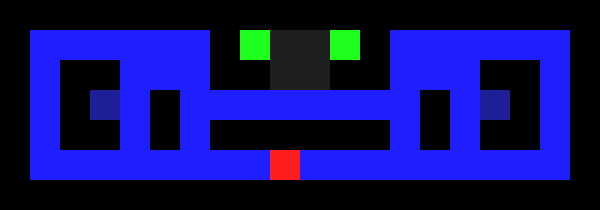

To provide more information to the network, we created an image with a two-state memory for the agents (Pacman and ghost). For such, let $I^{t-1}$ be the state image of the previous iteration, and let $P$ be the set of pixels containing an agent in $I^{t-1}$. We update new state image's past-located agent pixels to: $\forall p' \in P \rightarrow I^t(p') = \frac{I^{t-1}(p')}{4}$. The result can be seen in the picture below, where the Pacman moved to the right, and each ghost moved to either left or right (their previous position is represented in a dark tone).

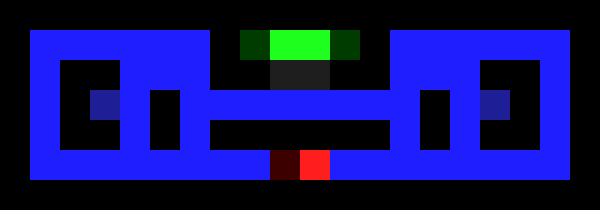

We conducted experiments using both the simple and the two-state-memory images.

Within the game, the state representation continues as provided by the default library. The image state representation is used only by the deep neural network.

# Experiments

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle


def read_pickle_file(filepath):
    with open(filepath, 'rb') as handle:
      data = pickle.load(handle) 

    return data


def movingaverage(in_interval, window_size):
    interval = np.array(in_interval)
    padded   = np.pad(interval, (window_size, window_size), 'constant', 
                      constant_values=(interval[0], interval[-1]))

    window= np.ones(int(window_size))/float(window_size)
    filt = np.convolve(padded, window, 'same')
    return filt[window_size : -window_size]

def plot_scores(scores_file, mean_window, title=""):
  f = open(scores_file,"r")
  scores = []
  for line in f: 
    line = line.rstrip("\n")
    scores.append(float(line))

  moving_mean = movingaverage(scores, mean_window)

  scores = np.array(moving_mean)[0:-mean_window]
  indices = np.arange(scores.shape[0])

  plt.plot(indices, scores)
  plt.ylabel('Mean Score')
  plt.xlabel('Episode')
  plt.title(title)
  plt.show()
mean_window = 200


## *Deep Q-Network (DQN)*

DQN is a variation of the Q-Learning algorithm that allows incorporating a deep neural network to learn a model used as a function approximator for state-action values. Unlike traditional deep-learning pipelines where the training process depends on a large annotated dataset, the authors of DQN propose building a data structure on the fly, namely *experience replay*, that stores the state-action-rewards of previous experiences. Using a Q-learning update rule, mini-batches are created extracting random samples from the *replay memory*, which are fed to the network that will learn by updating the weights by backpropagating the error gradient using Stochastic Gradient Descent.

In short, DQN uses a neural network with three convolutional layers for feature extraction, followed by a classifier composed of a fully connected layer and a decision layer. The decision layer outputs a number of values equal to the number of possible actions the agent can take. A greedy policy over the network's output represents the optimal policy learned by the network.

### Implementation Details

In our project, the neural network's decision layer outputs five values, one for each of the possible Pacman actions. We force the values of illegal actions to be a highly negative number so that the illegal actions are never part of the policy.

We used an $\epsilon$-greedy policy as learning policy for our agent. For the selection of $\epsilon$, we start using a fully exploration-based policy (*i.e.,* $\epsilon = 1$), and we decay its until it reaches a minimum of $\epsilon_m = 0.01$. The decay happens at every step until $\epsilon = \epsilon_m$, and it is computed to be $\epsilon = \epsilon - \frac{\epsilon - \epsilon_m}{e}$, where $e = 10000$ is a user-defined parameter that regulates the number of iterations it will take for $\epsilon$ to reach its minimum value.

In order for the network to train using randomized mini-batches, the network training only happens after the *replay memory* ($\mathcal{R}$) achieves a minimum number of observations. Also, we limit the size of $\mathcal{R}$ to account for hardware limitations. To do so, we model $\mathcal{R}$ as a queue (FIFO) and define its size during training to be $5000 \leq |\mathcal{R}| \leq 100000$. The minimum and maximum *replay memory* sizes were set empirically.

As Q-Learning, DQN is an off-policy method; thus, the policy being used during training is not always the same as the one being learned by the network. So, the learned policy is only copied for execution at every $u_t$ step, where $u_t = 500$ is a parameter we optimized empirically.

We store every step experienced by the agent at the *replay memory*, and after $|\mathcal{R}| > 5000$, we generate a batch at each new step by selecting random samples from the *replay memory*. The network weights are updated according to the gradient derived from the *Mean-Squared-Error* loss, where the network-predicted value of each state-action pair selected in the batch is compared to the next-state reward.

### Hyper-parameter Tuning

There are a few hyper-parameters to be tunned in DQN: (i) the learning rate $\alpha$; (ii) the policy update rate ($u_t$); (iii) the batch size ($B$); (iv) the number of episodes used for training ($N_{training}$), (v) the $\epsilon$ decay for the $\epsilon$-greedy policy ($e$). When optimizing the parameters for the classic reinforcement learning algorithms, we proposed doing a grid-search considering every parameter of the method. Here, because of the time it takes to fully train the neural network, running a grid-search in vast parameter space is unfeasible in the time frame available and hardware limitations we have.

So, although not ideal, most parameters were set empirically: We started by testing in simpler maps, changing the parameters until the agent converged to an adequate solution; then, we used the same parameters to our proposed layout and tuned the parameters again so the agent could provide an adequate solution in the new layout.

For the custom layout, we empirically set the number of training episodes to be $N_{training} = 1000$, the learning rate to be $\alpha = 0.00025$, the batch-size to be $b = 32$, and the model update rate to be $u_t = 500$. The same parameter values were used for both the deterministic and the stochastic environment.

For the classic Pacman game, we empirically set the number of training episodes to be $N_{training} = 2000$ for the small-classic layout. The same values of learning rate $\alpha$, batch-size $b$, and model update rate $u_t$ are used for the small-classic layout. 

Another important aspect that had to be tuned was the reward function. We empirically defined different reward functions for both types of games. For the custom layout, we define the function to be:

|   Value  |    Motive     |
|----------|:-------------:|
| -500     |  Lose         |
| 5000     |  Win          |
| -1       |  Single action|
| 100      |  Eats a food  |

We had to incorporate the agent's ability to eat capsules and scared ghosts for the classic Pacman game. The reward values that allowed the model to converge are described below:


|   Value  |    Motive     |
|----------|:-------------:|
| -500     |  Lose         |
| 5000     |  Win          |
| -1       |  Single action|
| 100      |  Eats a food  |
| 100      | Eats a capsule|
| 100      |  Eats a ghost |

###Results

We used the same hyper-parameters for the custom layout to train two different models: (i) using the simple map without the two-state memory; and (ii) using the two-state memory map. The goal is to see whether providing past-state information to the network can assist it to converge faster. The expectation is that the two-state memory would be beneficial for the deterministic environment, considering that the model could predict the position the ghosts will be in the next state.

For the deterministic environment, the DQN Agent took about 600 iterations to start winning, peaking consistently higher scores at the end of the training process after 800 iterations. The described behavior can be seen in the figure below, which shows a moving average of 50 episodes over time:

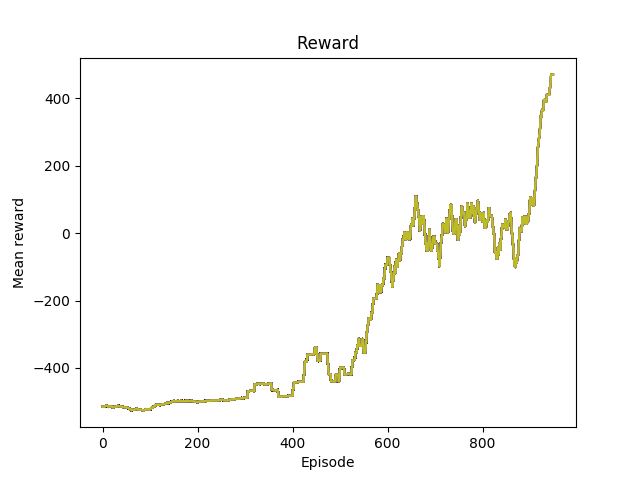

For the stochastic environment using the simple map, the DQN agent converged faster than the deterministic environment, requiring about 500 episodes to start winning; however, it peaked in about 800 episodes, similar to the deterministic one. The described behavior can be seen in the figure below:

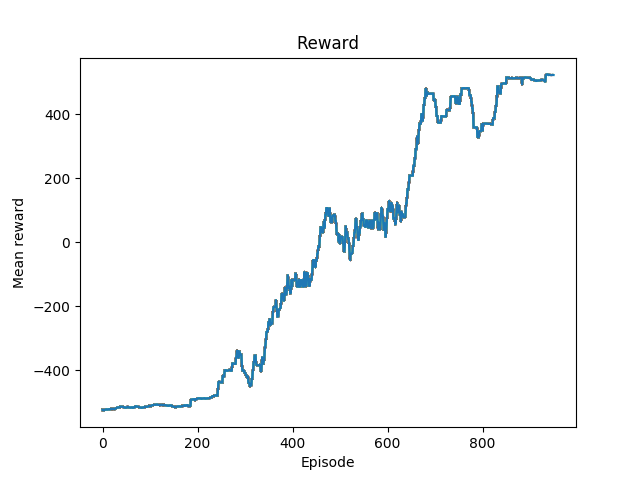

One interesting point to highlight is that the model generated training the agent in the stochastic environment might also be used to execute the agent in the deterministic environment achieving similar results. This illustrates the generalization capability of the model trained in this particular environment.

We then executed the same experiences using the two-state memory map. The additional information coded in the upgraded map did not significantly improve convergency time or the final agent solution. The figure below compares the simple map and the two-state memory map, where the simple-map results are in yellow and the two-state map in blue.

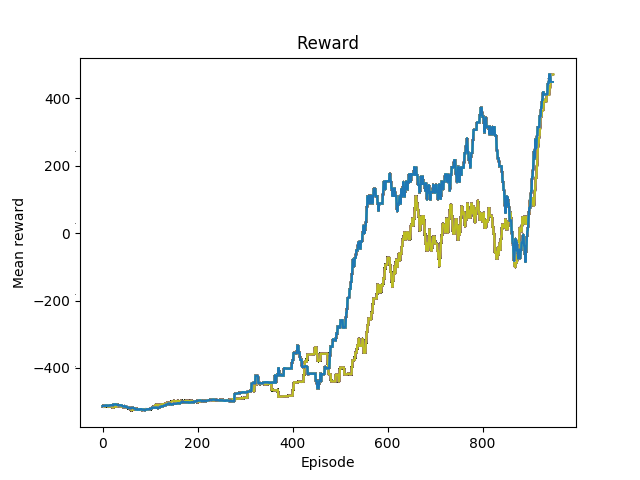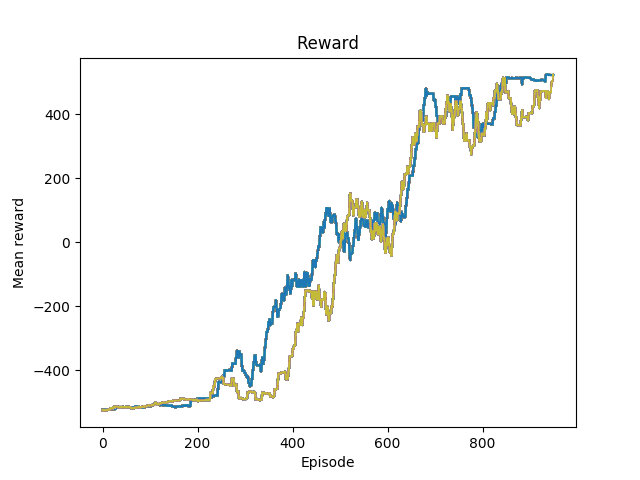

Because the primary goal of the two-state memory was to provide information of where the ghosts would be in the next state, we expected it to provide a faster convergency for the deterministic environment. There is a significant score improvement when the DQN agent starts to win episodes (around episode 500). However, there is no improvement in the number of episodes for the agent to converge to a peak solution.

As expected, there was no considerable difference between both maps regarding the stochastic environment. Because our experiments did not validate the two-state memory successful, we discarded this idea for the subsequent experiments.

To train the agent with the optimal parameters in the **deterministic environment** and save the model in `dqn_deterministic.h5` use the following command line:
```
python2.7 train.py -p DQNAgent -g PatrolGhost -l customMaze -n 1001 -x 1000 -a map_size="12.10.3",output_model=dqn_deterministic.h5
```

To load the model in `dqn_deterministic.h5` and run the game 10 times with graphics use the following command line:
```
python2.7 pacman.py -p DQNAgent -g PatrolGhost -l customMaze -n 10 -a pretrained_model="dqn_deterministic.h5"
```

To load the model in `dqn_deterministic.h5` and run the game 10 times without graphics use the following command line:
```
python2.7 pacman.py -p DQNAgent -g PatrolGhost -l customMaze -n 10 -a pretrained_model="dqn_deterministic.h5" -q
```

To train the agent with the optimal parameters in the **stochastic environment** and save the model in `ql_model.csv` use the following command line:
```
python2.7 train.py -p DQNAgent -g HorizontalRandomGhost -l customMaze -n 1001 -x 1000 -a map_size="12.10.3",output_model=dqn_stochastic.h5
```

To load the model in `dqn_stochastic.h5` and run the game 10 times with graphics use the following command line:
```
python2.7 pacman.py -p DQNAgent -g HorizontalRandomGhost -l customMaze -n 10 -a pretrained_model="dqn_stochastic.h5"
```

To load the model in `dqn_stochastic.h5` and run the game 10 times without graphics use the following command line:
```
python2.7 pacman.py -p DQNAgent -g HorizontalRandomGhost -l customMaze -n 10 -a pretrained_model="dqn_stochastic.h5" -q
```

We use only the simple map without the two-state memory for the small-classic layout. The DQN Agent took about 1500 iterations to start winning. However, the agent did not consistently achieve higher scores, as shown in the figure below. There is a reward decay from around iteration 1600 to around iteration 1700. From around iteration 1700 onwards, we see that the agent starts consistently obtaining higher scores again, recovering and improving its winning capability. The figure below was generated using a moving average of 50 episodes over time:

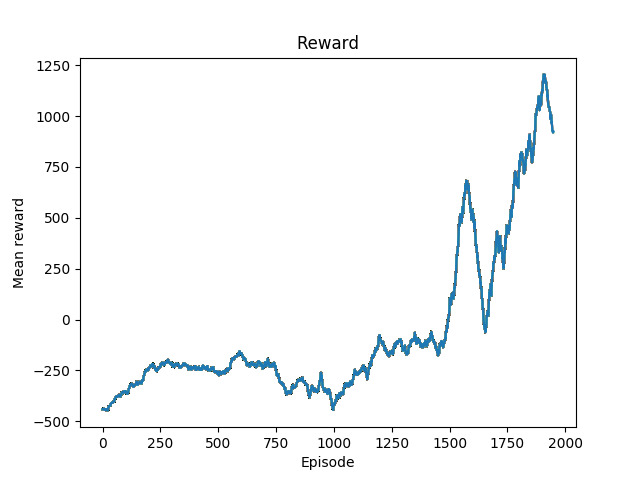

### Comparison between DQN and Q-Learning

It can be seen from the figures below that in the experiments of the previous report, the agent trained with Q-Learning converges to good scores from around iteration 1500 onwards for the deterministic environment and from around iteration 1750 onwards for the stochastic environment. In contrast, from the figures above, it can be observed that the agent trained with DQN starts converging to good scores from around iteration 900 onwards for the deterministic environment and from around iteration 600 onwards for the stochastic environment. 

From these results, it is evident that DQN achieves similar results to Q-Learning in a considerably lower number of iterations (episodes), showcasing its efficiency and superiority in this scenario. Furthermore, DQN allows generalizing more complex layouts, as shown with the small-classic layouts. The small-classic layout increases the number of states considerably by including capsules and the random behavior of the ghosts. In this setting, it becomes a daunting task for Q-learning to start achieving good scores, let alone winning the game, in a reasonable number of iterations. 

Therefore, we conclude that DQN shows a significant improvement over Q-Learning by introducing neural networks in the training process.

**Convergence of Q-Learning in the Deterministic Environment**

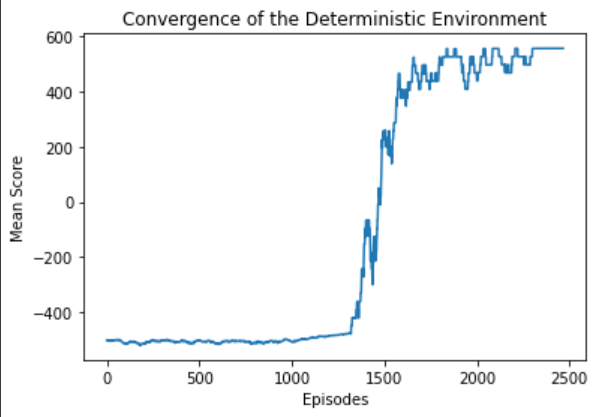

**Convergence of Q-Learning in the Stochastic Environment**

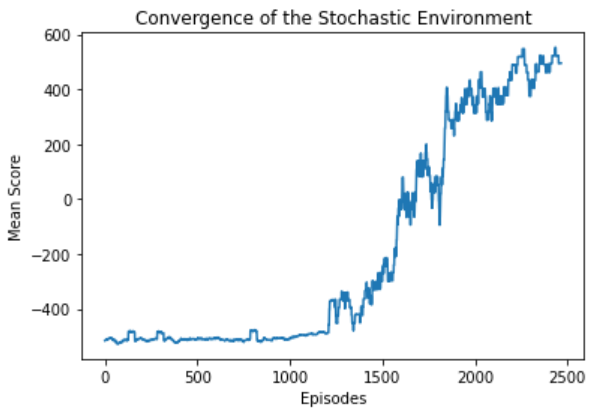

To train the agent with the optimal parameters using the **small-classic** layout and save the model in `dqn_smallClassic.h5` use the following command line:
```
python2.7 train.py -p DQNAgent -l smallClassic -n 2001 -x 2000 -a map_size="7.20.3",output_model=dqn_smallClassic.h5
```

To load the model in `dqn_smallClassic.h5` and run the game 10 times with graphics use the following command line:
```
python2.7 pacman.py -p DQNAgent -l smallClassic -n 10 -a pretrained_model="dqn_smallClassic.h5"
```

To load the model in `dqn_stochastic.h5` and run the game 10 times without graphics use the following command line:
```
python2.7 pacman.py -p DQNAgent -l smallClassic -n 10 -a pretrained_model="dqn_smallClassic.h5" -q
```

## Monte Carlo Policy Gradient (REINFORCE)


Unlike Q-learning, which is a value-based method, REINFORCE is a policy-based method, which means that the model directly maps an input to an action ($S \rightarrow a$). In this work, we used a deep neural network that receives as input an image as showed early, the network has convolutional layers that extract features from the image and a linear block reduces those features to the number of actions size, then a softmax function outputs probabilities of each action as illustrated in the following figure.

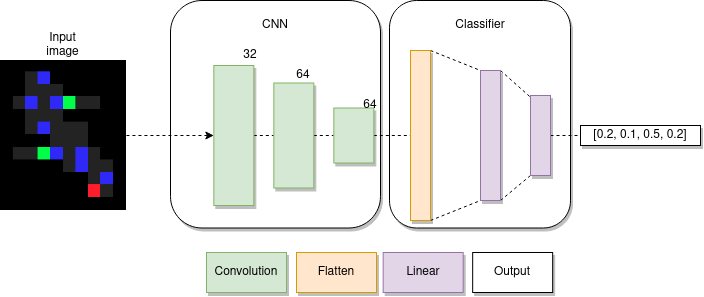

Besides that, REINFORCE follows the following algorithm:


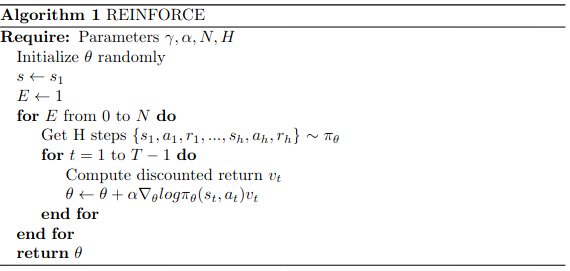

### Implementation Details


Since We have used a neural network, We changed the update step by computing the loss $- \sum log\pi_{\theta}(s_t, a_t)v_t$ and performing stochastic gradient descent (using the negative due to the gradient descent of python libraries). Moreover, since we initialize our model randomly, the output is highly random initially, removing the necessity of an *e-greedy* policy. 


The network produces a probability for each action, for example [0.1, 0.2, 0.5, 0.2] for actions [North, East, South, West], which can be a problem for illegal actions at the beginning of training. To overcome this, We added one more reward with the value of $-5$ relative to an illegal action.


Also, we noticed that REINFORCE lost a lot initially, and a negative reward for each loss did not offer much (the Pacman was too afraid); for that reason, we changed the value of losing from $-500$ to $-50$.


  Due to the custom loss used in REINFORCE, we implemented the algorithm using Pytorch, not Keras (used in DQN).


### Hyper-Parameters Tunning

REINFORCE has a few hyper-parameters which are: 

, size of each trajectory $T$, 

1.   Total number of Episodes $N$;
2.   Horizon, or size of each trajectory $H$;
3.   Learning rate $\alpha$;
4.   Discount factor $\gamma$.


Furthermore, similar to the DQN the time it takes to fully train the neural network, running a grid-search in vast parameter space is unfeasible in the time frame and hardware limitations. Moreover, all parameters were set empirically.

However, we notice the impact factor of each parameter; for example, the discount factor needs to be closer to 1 (something between 0.9 and 1). Otherwise, the discounted return will be too low, and early steps will not update at all. 

Since our problem is to win, the higher reward is at the end of the episode; thus, it makes sense only to update the model at its end. Therefore, we used $H = 1000000$ to ensure that the model will only update at the end of the episode. We tested using a small value for $H$, something like (32, 500,1000,..), but it did not help our problem.

The learning rate was chosen small because REINFORCE is a high variance method, with a loss that varies a lot. We found that something between $\alpha \sim [1e-5, 5 e-6]$ was the best choice.



### Results

For the deterministic problem we notice that $N=5000$, $\alpha=0.00001$ and $\gamma =0.99$ was the best parameters, which can be trained by the following command (takes time):

In [2]:
#python pacman.py -n 5001 -x 5000 -l customMaze -p REAgent -g PatrolGhost -a maxa=2000,lr=0.00005,gamma=0.99,log_name=reinforce_det_log.pickle -o reinforce_det.pt -q

this will save out logs in reinforce_det_log.pickle file, which can be used to plot the curves

Text(0,0.5,'N. Actions')

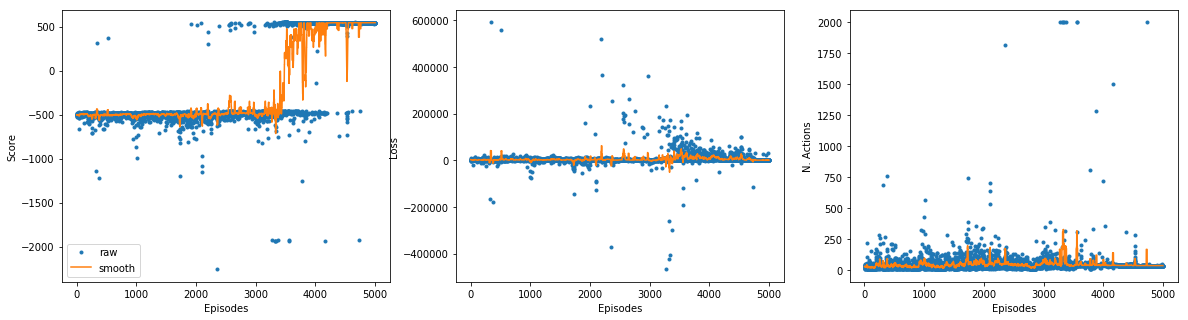

In [3]:
reinforce_d_data = read_pickle_file("reinforce_output/reinforce_det_log.pickle")

Nd = len(reinforce_d_data['score'])
episodes_d = np.linspace(1,Nd,Nd)


fig, axs = plt.subplots(1,3, figsize=(20,5))

axs[0].plot(episodes_d, np.array(reinforce_d_data['score']),'.',label='raw')
axs[0].plot(episodes_d, movingaverage(np.array(reinforce_d_data['score']),15),
            '-', label='smooth')
axs[0].set_xlabel("Episodes")
axs[0].set_ylabel("Score")
axs[0].legend(loc="lower left")

axs[1].plot(episodes_d, np.array(reinforce_d_data['loss']),'.')
axs[1].plot(episodes_d, movingaverage(np.array(reinforce_d_data['loss']),15),
            '-', label='smooth')
axs[1].set_xlabel("Episodes")
axs[1].set_ylabel("Loss")


axs[2].plot(episodes_d, np.array(reinforce_d_data['actions']),'.')
axs[2].plot(episodes_d, movingaverage(np.array(reinforce_d_data['actions']),15),
            '-', label='smooth')
axs[2].set_xlabel("Episodes")
axs[2].set_ylabel("N. Actions")

In [4]:
#python pacman.py -n 5001 -x 5000 -l customMaze -p REAgent -g HorizontalRandomGhost -a maxa=5000,lr=0.00005,gamma=0.9,log_name=reinforce_st_log.pickle -o reinforce_st.pt -q

Text(0,0.5,'N. Actions')

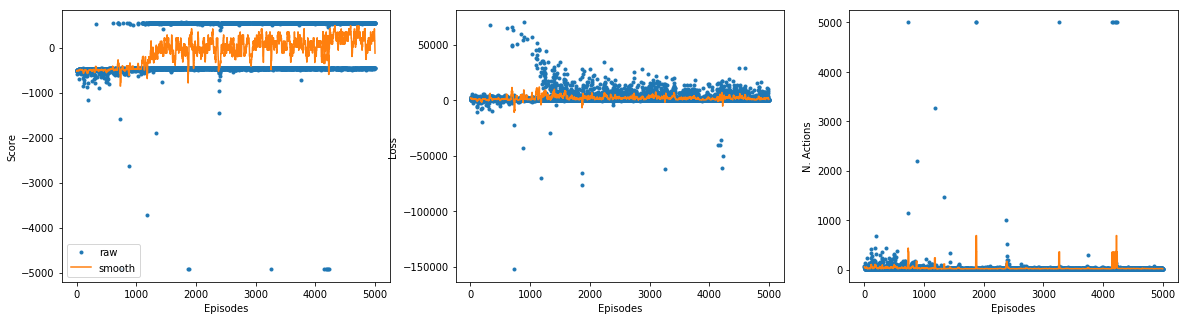

In [5]:
reinforce_s_data = read_pickle_file("reinforce_output/reinforce_st_log.pickle")

Ns = len(reinforce_s_data['score'])
episodes_s = np.linspace(1,Ns,Ns)


fig, axs = plt.subplots(1,3, figsize=(20,5))

axs[0].plot(episodes_d, np.array(reinforce_s_data['score']),'.',label='raw')
axs[0].plot(episodes_d, movingaverage(np.array(reinforce_s_data['score']),15),
            '-', label='smooth')
axs[0].set_xlabel("Episodes")
axs[0].set_ylabel("Score")
axs[0].legend(loc="lower left")

axs[1].plot(episodes_d, np.array(reinforce_s_data['loss']),'.')
axs[1].plot(episodes_d, movingaverage(np.array(reinforce_s_data['loss']),15),
            '-', label='smooth')
axs[1].set_xlabel("Episodes")
axs[1].set_ylabel("Loss")


axs[2].plot(episodes_d, np.array(reinforce_s_data['actions']),'.')
axs[2].plot(episodes_d, movingaverage(np.array(reinforce_s_data['actions']),15),
            '-', label='smooth')
axs[2].set_xlabel("Episodes")
axs[2].set_ylabel("N. Actions")

### Comparison between REINFORCE and Monte Carlo Control


In the previous work, we implemented the tabular version of Monte Carlo Control, which successfully converged for the deterministic and stochastic problem, but the linear feature approximation version of Monte Carlo did not learn at all for the same maps.

Here the REINFORCE method also converged for both environments and even converged faster than the MC Control as illustrated in the following cells:

Text(0.5,1,'Mean Scores for Stochastic Environment')

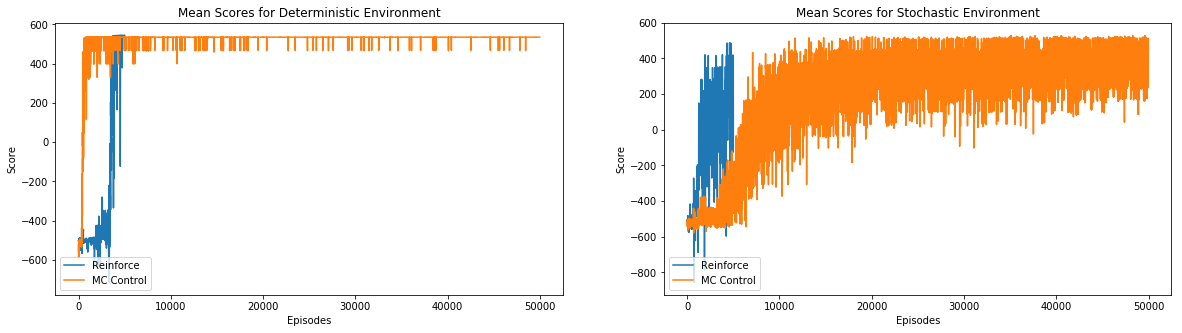

In [6]:
def read_txt_files(scores_file, mean_window, title=""):
  f = open(scores_file,"r")
  scores = []
  for line in f: 
    line = line.rstrip("\n")
    scores.append(float(line))

  moving_mean = movingaverage(scores, mean_window)

  scores = np.array(moving_mean)[0:-mean_window]
  indices = np.arange(scores.shape[0])

  return indices, scores



det_mc_data = read_txt_files('mc_output/scores-mc-deterministic.txt', 15)
sto_mc_data = read_txt_files('mc_output/scores-mc-stochastic.txt', 15)



fig, axs = plt.subplots(1,2, figsize=(20,5))

axs[0].plot(episodes_d, movingaverage(np.array(reinforce_d_data['score']),15),
            '-', label='Reinforce')
axs[0].plot(det_mc_data[0], det_mc_data[1],'-', label='MC Control')
axs[0].set_xlabel("Episodes")
axs[0].set_ylabel("Score")
axs[0].legend(loc="lower left")
axs[0].set_title('Mean Scores for Deterministic Environment')



axs[1].plot(episodes_d, movingaverage(np.array(reinforce_s_data['score']),15),
            '-', label='Reinforce')
axs[1].plot(sto_mc_data[0], sto_mc_data[1],'-', label='MC Control')
axs[1].set_xlabel("Episodes")
axs[1].set_ylabel("Score")
axs[1].legend(loc="lower left")
axs[1].set_title('Mean Scores for Stochastic Environment')




### Reinforce in the classic layout

The figure above shows the results for the classic layout, notice that there is a slightly improvement in the score plot, but the model was not able to fully learn this map, which could be caused by the high varience of REINFORCE.

![loss](reinforce_output/loss_small.png)

Also, the gif above shows the execution of this layout, notice how the pacman eats foods but did not win the game.

![small](reinforce_output/reinforce_smallClassic.gif)

# Conclusion


In this work we implemented two Deep Reinforcement Learning Algorithms, DQN and REINFORCE. Both of them performed well on our custom map (for deterministic and stochastic environment), but DQN performed also well into a classic map, different from REINFORCE that did not play well this classic Map.

# How to run all experiments

In [14]:
# To run DQN with deterministic environment

!python pacman.py -p DQNAgent -g PatrolGhost -l customMaze -n 1 -a map_size=12.10.3,pretrained_model=dqn_models/deterministic.h5 -q

Using Theano backend.
Pacman emerges victorious! Score: 549
('Average Score:', 549.0)
('Scores:       ', '549.0')
Win Rate:      1/1 (1.00)
('Record:       ', 'Win')


In [15]:
# To run DQN with stochastic environment
!python pacman.py -p DQNAgent -g HorizontalRandomGhost -l customMaze -n 1 -a map_size=12.10.3,pretrained_model=dqn_models/stochastic.h5 -q

Using Theano backend.
Pacman emerges victorious! Score: 549
('Average Score:', 549.0)
('Scores:       ', '549.0')
Win Rate:      1/1 (1.00)
('Record:       ', 'Win')


In [17]:
# To run DQN with classic environment
!python pacman.py -p DQNAgent -l smallClassic -n 1 -a pretrained_model=dqn_models/smallClassic.h5 -q

Using Theano backend.
Pacman emerges victorious! Score: 849
('Average Score:', 849.0)
('Scores:       ', '849.0')
Win Rate:      1/1 (1.00)
('Record:       ', 'Win')


In [24]:
# to run REINFORCE with deterministic environment
!python pacman.py -p REAgent -l customMaze -n 1 -g PatrolGhost -a map_size=3.10.12 -i reinforce_output/reinforce_det.pt -q

Using Theano backend.
Pacman emerges victorious! Score: 547
('Average Score:', 547.0)
('Scores:       ', '547.0')
Win Rate:      1/1 (1.00)
('Record:       ', 'Win')


In [23]:
# to run REINFORCE with stochastic environment
!python pacman.py -p REAgent -l customMaze -n 1 -g HorizontalRandomGhost -a map_size=3.10.12 -i reinforce_output/reinforce_st.pt -q

Using Theano backend.
Pacman emerges victorious! Score: 557
('Average Score:', 557.0)
('Scores:       ', '557.0')
Win Rate:      1/1 (1.00)
('Record:       ', 'Win')


In [25]:
# to run REINFORCE with classic environment
!python pacman.py -p REAgent -l smallClassic -n 1 -g HorizontalRandomGhost -a map_size=3.20.7 -i reinforce_output/small.pt -q

Using Theano backend.
Pacman died! Score: -4539
('Average Score:', -4539.0)
('Scores:       ', '-4539.0')
Win Rate:      0/1 (0.00)
('Record:       ', 'Loss')


# Contributions

Leonardo: Implemented DQN and perfom experiments on our custom map; Written Introduction and DQN section of this work and revised our code.

David: Helped Leonardo with DQN code, experimented with classical map, written DQN section and revised our code.

Matheus: Implemented REINFORCE and performed experiments with custom map and small classic map, written REINFORCE section and revised code.

Walter: Revised code and helped with this document.

# References








[1] - Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. MIT press, 2018.

[2] - Alpaydin, Ethem. Introduction to machine learning. MIT press, 2020.